# Определение возраста покупателей

# План выполнения проекта:

 - Bсследовательский анализ набора фотографий.

 - Подготовка данных к обучению. 

 - Обучение нейронной сети
 
 - Выводы по результатм работы, оценка качества полученной модели

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим наши данные

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Посмотрим на размер выборки

In [3]:
print("Размер выборки:", len(train_gen_flow))

Размер выборки: 238


Построим график распределения возраста в выборке

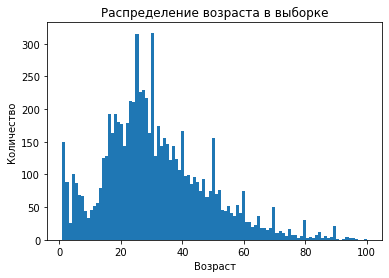

In [4]:
ages = train_gen_flow.labels
plt.hist(ages, bins=100)
plt.title("Распределение возраста в выборке")
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.show()

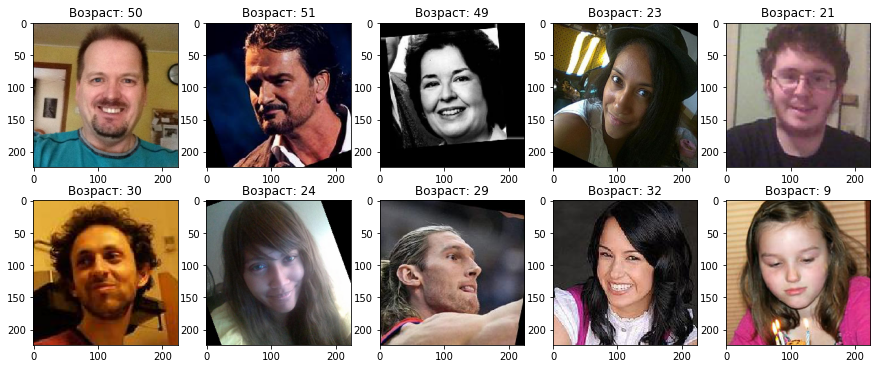

In [5]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

for i in range(10):
    batch = next(train_gen_flow)
    img = batch[0][0]
    age = batch[1][0]
    axs[i].imshow(img)
    axs[i].set_title(f"Возраст: {age}")

# Вывод
В наборе данных обнаружено неравномерное количество фотографий для разных категорий возрастов. Это может негавтино отразится в будущем на качестве обучения модели.

По фотографиям можно сделать следующие выводы

 - В наборе присутствуют как цветные, так и черно-белые фото.

 - Все фото приведеные к одному масштабу.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import pandas as pd

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
def load_train(path):
    df = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                      directory=path+'final_files/',    
                                                      x_col='file_name',
                                                      y_col='real_age',
                                                      target_size=(224,224),
                                                      batch_size=32,
                                                      class_mode='raw',
                                                      subset='training',  
                                                      seed = 12345)
    return train_datagen_flow


def load_test(path):
    df = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255.,
                                      validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                                         directory=path +'final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224,224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',     
                                                         seed = 12345)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights= '/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 62s - loss: 230.6711 - mae: 10.8059 - val_loss: 796.4240 - val_mae: 23.3096
Epoch 2/10
178/178 - 39s - loss: 60.8476 - mae: 5.8950 - val_loss: 683.3381 - val_mae: 21.1437
Epoch 3/10
178/178 - 38s - loss: 28.9099 - mae: 4.1413 - val_loss: 446.8225 - val_mae: 16.3376
Epoch 4/10
178/178 - 40s - loss: 18.1059 - mae: 3.2941 - val_loss: 139.7845 - val_mae: 8.8800
Epoch 5/10
178/178 - 39s - loss: 14.4752 - mae: 2.9358 - val_loss: 79.0830 - val_mae: 6.8314
Epoch 6/10
178/178 - 40s - loss: 12.0683 - mae: 2.6637 - val_loss: 82.0886 - val_mae: 6.9418
Epoch 7/10
178/178 - 39s - loss: 10.2762 - mae: 2.4578 - val_loss: 65.8349 - val_mae: 6.1585
Epoch 8/10
178/178 - 39s - loss: 9.4584 - mae: 2.3315 - val_loss: 65.4059 - val_mae: 6.0941
Epoch 9/10
178/178 - 39s - loss: 9.8720 - mae: 2.3568 - val_loss: 69.8866 - val_mae: 6.3399
Epoch 10/10
178/178 - 40s - loss: 9.1847 - mae: 2.2555 - val_loss: 65.3835 - val_mae: 6.1592
60/60 - 10s - loss: 65.3835 - mae: 6.1592
Test MAE: 6.1592

```

## Анализ обученной модели

Для получения наилучшего качества модели я использовал: 
 - алгоритм Adam с частотой обучения lr=0.0001 
 - архитектуру RestNet50
 - количествомэпох 10
 Требуемого результата MAE<8 удалось добиться без использования аугментации

Модель на тестовых данных показала результат MAE = 6,1592, что позволяет использовать ее в качестве решения для поставленной задачи